In [1]:
%load_ext autoreload
%autoreload 2

import auxilary.util as util
import auxilary.grid2op_util as g2o_util
import numpy as np
import os

import pandas as pd
import ipdb
import matplotlib.pyplot as plt

import grid2op
import re
import data_preprocessing_analysis.imitation_data_preprocessing as idp
import functools
from auxilary.generate_action_space import action_identificator
import json
import math
from sklearn.metrics import confusion_matrix
from pathlib import Path
import collections
from scipy.stats import entropy
from scipy.spatial import distance
from tqdm import tqdm

In [2]:
config = util.load_config()
processed_data_path = config['paths']['processed_tutor_imitation']
con_matrix_path = config['paths']['con_matrix_cache']
fstats_path = config['paths']['feature_statistics']

line_disabled_to_consider = [-1,0,1,2,3,4,5,6,10,12,13,15,16,19]
line_group1 = [-1,0,1,2,3,4,5,6,12]
line_group2 = [13,15,16,19]

# Data Analysis

In [3]:
counters = {} 
hash_to_act = {}
hash_to_res = {}
n_sub = 14

for i in np.arange(-1,20):
    counters[i] = {
        'n_datapoints':0,
        'n_days_completed':0,
        'n_chronics':0,
        'set_hash': collections.Counter(),
        'res_hash': collections.Counter(),
        'sub_changed': (n_sub+1) * [0],
        'changed_subs_n': n_sub * [0],
        'sub_info': []
    }
        
        

for f in tqdm(list(Path(processed_data_path).rglob('*.json'))):
    with open(f, 'r') as file:
            dps = json.loads(file.read())
            
    line_disabled = dps[0]['line_disabled']
    
    counters[line_disabled]['n_chronics']+=1
    counters[line_disabled]['n_days_completed']+=dps[0]['dayscomp']
    for dp in dps:
        #Increase n. datapoints
        counters[line_disabled]['n_datapoints']+=1
        
        #Count set_topo_vect
        hsh_set = util.hash_nparray(np.array(dp['set_topo_vect']))
        if hsh_set not in hash_to_act:
            hash_to_act[hsh_set] = dp['set_topo_vect']
        counters[line_disabled]['set_hash'][hsh_set]+=1
        
        #Count res_topo_vect
        hsh_res = util.hash_nparray(np.array(dp['res_topo_vect']))
        if hsh_res not in hash_to_res:
            hash_to_res[hsh_res] = dp['res_topo_vect']
        counters[line_disabled]['res_hash'][hsh_res]+=1
        
        #Count substations affected
        action_per_sub = g2o_util.tv_groupby_subst(dp['set_topo_vect'],dp['sub_info'])
        try:
            changed_subs_id = [np.any(a) for i,a in enumerate(action_per_sub)].index(True)
            counters[line_disabled]['sub_changed'][changed_subs_id] += 1
        except:
            counters[line_disabled]['sub_changed'][-1] += 1

        #Count topological depth of resulting topologies
        #ASSUMPTION: reference topology is the topology where all objects are connected to bus 1
        res_per_sub = g2o_util.tv_groupby_subst(dp['res_topo_vect'],dp['sub_info'])
        changed_subs_n = sum([2 in res for i,res in enumerate(res_per_sub)])
        counters[line_disabled]['changed_subs_n'][changed_subs_n] += 1
        
        #Set sub info
        counters[line_disabled]['sub_info'] = dp['sub_info']


100%|██████████| 16/16 [00:00<00:00, 98.45it/s]


#### Number of chronics

In [4]:
sum([v['n_chronics']for k,v in counters.items() if k in line_disabled_to_consider])

14

#### Percentage days completed

In [5]:
print([(k,v['n_days_completed']/(28*v['n_chronics'])) if v['n_chronics']!=0 else None
       for k,v in counters.items() 
       if k in line_disabled_to_consider])

[(-1, 1.0), None, (1, 1.0), None, None, None, None, None, None, None, None, (15, 0.875), None, None]


In [6]:
print('Total:',
    sum([v['n_days_completed']for k,v in counters.items() if k in line_disabled_to_consider])/ \
    sum([28*v['n_chronics']for k,v in counters.items() if k in line_disabled_to_consider]))
print('Group 1:',
    sum([v['n_days_completed']for k,v in counters.items() if k in line_group1])/ \
    sum([28*v['n_chronics']for k,v in counters.items() if k in line_group1]))
print('Group 2:',
    sum([v['n_days_completed']for k,v in counters.items() if k in line_group2])/ \
    sum([28*v['n_chronics']for k,v in counters.items() if k in line_group2]))

Total: 0.9821428571428571
Group 1: 1.0
Group 2: 0.875


#### Number of datapoints

In [7]:
[(k,v['n_datapoints'])for k,v in counters.items() if k in line_disabled_to_consider]

[(-1, 97),
 (0, 0),
 (1, 156),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (10, 0),
 (12, 0),
 (13, 0),
 (15, 146),
 (16, 0),
 (19, 0)]

In [8]:
N_total = sum([v['n_datapoints']for k,v in counters.items() if k in line_disabled_to_consider])
N_group1 = sum([v['n_datapoints']for k,v in counters.items() if k in line_group1])
N_group2 = sum([v['n_datapoints']for k,v in counters.items() if k in line_group2])

print('Total:', N_total)
print('Group 1:', N_group1)
print('Group 2:', N_group2)

Total: 399
Group 1: 253
Group 2: 146


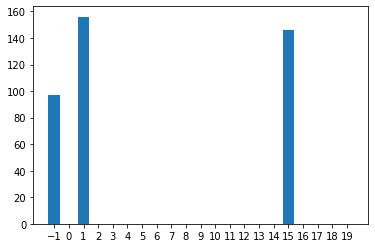

In [9]:
plt.bar(line_disabled_to_consider,
        [counters[l]['n_datapoints'] for l in np.arange(-1,20) if l in line_disabled_to_consider])
ax = plt.gca()
_ = ax.set_xticks(np.arange(-1,20))

#### Action statistics

Number of actions

In [10]:
[(k,len(v['set_hash']))
 for k,v in counters.items() 
 if k in line_disabled_to_consider]

[(-1, 11),
 (0, 0),
 (1, 16),
 (2, 0),
 (3, 0),
 (4, 0),
 (5, 0),
 (6, 0),
 (10, 0),
 (12, 0),
 (13, 0),
 (15, 29),
 (16, 0),
 (19, 0)]

Percentage of do-nothing actions

In [11]:
#Find the hashes that are do-nothing actions. Should not be higher than two. 
do_nothing_action_hashes = [h for h,t 
                            in hash_to_act.items() 
                            if sum(t)==0]
assert len(do_nothing_action_hashes) < 3

[(k,sum([v['set_hash'][h] for h in do_nothing_action_hashes])/v['n_datapoints'])
 for k,v in counters.items() 
 if k in line_disabled_to_consider and v['n_datapoints'] != 0]

[(-1, 0.0), (1, 0.12179487179487179), (15, 0.2534246575342466)]

In [12]:
sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
          /v['n_datapoints']
         for k,v in counters.items() 
         if k in line_disabled_to_consider and v['n_datapoints'] != 0])/N_total

0.000940399822879996

In [13]:
print('Total:',
     sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
         for k,v in counters.items() 
         if k in line_disabled_to_consider and v['n_datapoints'] != 0])/N_total)
print('Group 1:',
     sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
         for k,v in counters.items() 
         if k in line_group1 and v['n_datapoints'] != 0])/N_group1)
print('Group 2:',
     sum([sum([v['set_hash'][h] for h in do_nothing_action_hashes])
         for k,v in counters.items() 
         if k in line_group2 and v['n_datapoints'] != 0])/N_group2)

Total: 0.14035087719298245
Group 1: 0.07509881422924901
Group 2: 0.2534246575342466


Entropy of the action distribution

In [14]:
[(k,entropy(list(v['set_hash'].values()))) 
 for k,v in counters.items() 
 if k in line_disabled_to_consider]

[(-1, 1.4266258070237605),
 (0, 0.0),
 (1, 1.8519240180352696),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (10, 0.0),
 (12, 0.0),
 (13, 0.0),
 (15, 2.6086765950000337),
 (16, 0.0),
 (19, 0.0)]

In [15]:
#Getting actions into format so that actions at substations
standard_sub_info = [3, 6, 4, 6, 5, 6, 3, 2, 5, 3, 3, 3, 4, 3]
    
for i in np.arange(-1,20):
    act_counter = counters[i]['set_hash']
    unique_act_counter = collections.Counter()
    for h,c in act_counter.items():
        a = hash_to_act[h]
        a_per_substation = g2o_util.tv_groupby_subst(a,counters[i]['sub_info'])
        try:
            changed_subs_id = [np.any(a) for a in a_per_substation].index(True)
            action = (changed_subs_id,tuple(a_per_substation[changed_subs_id]),
                      None if standard_sub_info[changed_subs_id]==counters[i]['sub_info'][changed_subs_id] else i)
            unique_act_counter[action] += c
        except ValueError:
            unique_act_counter[-1] += c
    counters[i]['unique_set_act'] = unique_act_counter
    
combined_act_counter = collections.Counter()
act_counter_group1 = collections.Counter()
act_counter_group2 = collections.Counter()
for i in np.arange(-1,20):
    combined_act_counter = combined_act_counter + counters[i]['unique_set_act']
    if i in line_group1:
        act_counter_group1 += act_counter_group1 + counters[i]['unique_set_act']
    elif  i in line_group2:
        act_counter_group2 += act_counter_group2 + counters[i]['unique_set_act']
        

In [16]:
tups = list(combined_act_counter.keys())
tups = sorted([t for t in tups if type(t)==tuple])
tups = [-1] + tups
tups

colormap = {
    -1:'k',
    1:'b',
    2:'g',
    3:'r',
    4:'c',
    5:'m',
    8:'y',
    12:'k',
}

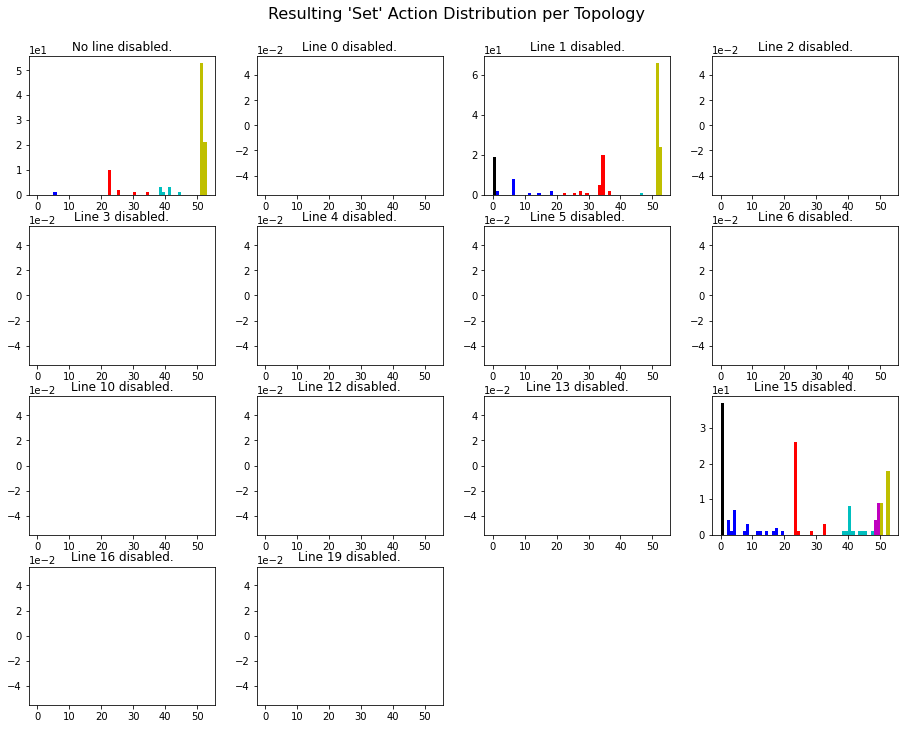

In [17]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()

for plt_i, c_i in enumerate(line_disabled_to_consider):
    act_counter = counters[c_i]['unique_set_act']
    weight = [act_counter[i] for i in tups]

    _, _, patches = axs[plt_i].hist(range(len(weight)), weights=weight,bins=range(len(weight)))
    axs[plt_i].title.set_text(f'Line {c_i} disabled.' if c_i>-1 else 'No line disabled.')
    
    #Applying colors
    for j,t in enumerate(tups[:-1]):
        if type(t) == int:
            continue
        patches[j].set_facecolor(colormap[t[0]])
    patches[0].set_facecolor(colormap[-1])
    
    axs[plt_i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Resulting \'Set\' Action Distribution per Topology', fontsize=16, y=1.05)
fig.savefig('figures/action_distribution_per_topology.png', dpi=300)

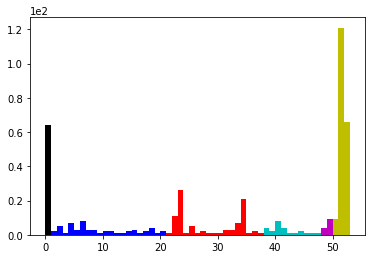

In [18]:
weight = [combined_act_counter[i] for i in tups]
_, _, patches = plt.hist(range(len(weight)), weights=weight,bins=range(len(weight)))

#Applying colors
for j,t in enumerate(tups[:-1]):
    if type(t) == int:
        continue
    patches[j].set_facecolor(colormap[t[0]])
patches[0].set_facecolor(colormap[-1])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

In [19]:
print('Total:',
    len(combined_act_counter.most_common()),
      entropy(list(combined_act_counter.values())))
print('Group 1:',
      len(act_counter_group1.most_common()),
      entropy(list(act_counter_group1.values())))
print('Group 2:',
      len(act_counter_group2.most_common()),
      entropy(list(act_counter_group2.values())))

Total: 54 2.8097202928212752
Group 1: 22 1.7282795422387598
Group 2: 29 2.6086765950000337


/home/matthijs/Software/anaconda3/lib/python3.8/site-packages/scipy/spatial/distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


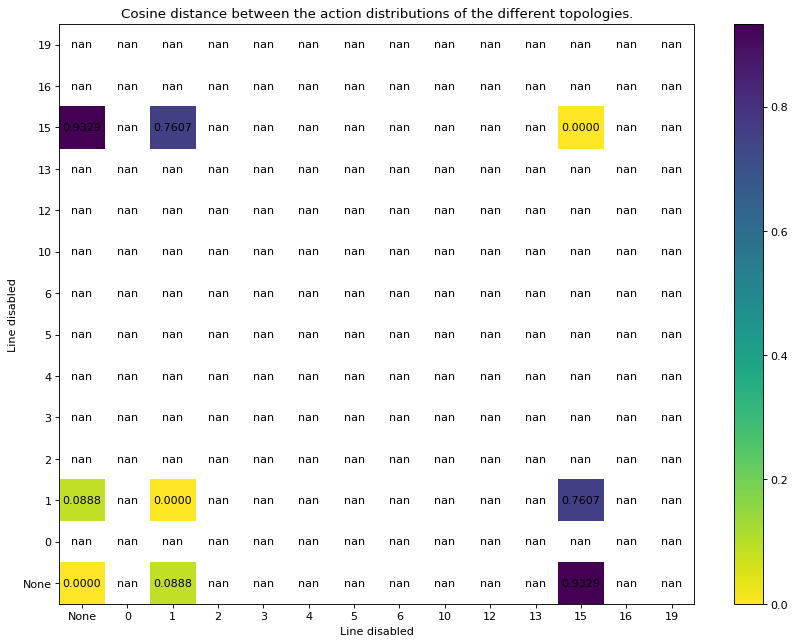

In [20]:
plt.figure(figsize=[2*6.4, 2*4.8], dpi=80)

data = np.random.rand(len(line_disabled_to_consider), len(line_disabled_to_consider))
for iy,y in enumerate([counters[i]['unique_set_act'] for i in line_disabled_to_consider]):
    for ix,x in enumerate([counters[i]['unique_set_act'] for i in line_disabled_to_consider]):
        cosine = distance.cosine([y[a] for a in combined_act_counter.keys()],
                                     [x[a] for a in combined_act_counter.keys()])
        data[iy,ix] = cosine
heatmap = plt.pcolor(data,cmap='viridis_r')

for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % data[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

plt.colorbar(heatmap)
plt.xticks(np.arange(0.5,len(line_disabled_to_consider)+0.5),['None']+line_disabled_to_consider[1:])
plt.yticks(np.arange(0.5,len(line_disabled_to_consider)+0.5),['None']+line_disabled_to_consider[1:])
plt.ylabel('Line disabled')
plt.xlabel('Line disabled')
plt.title('Cosine distance between the action distributions of the different topologies.')
plt.savefig('figures/cosine_distance_actions.png', dpi=300)
plt.show()

In [21]:
(len(combined_act_counter.most_common()),entropy(list(combined_act_counter.values())))

(54, 2.8097202928212752)

### Topology Distribution

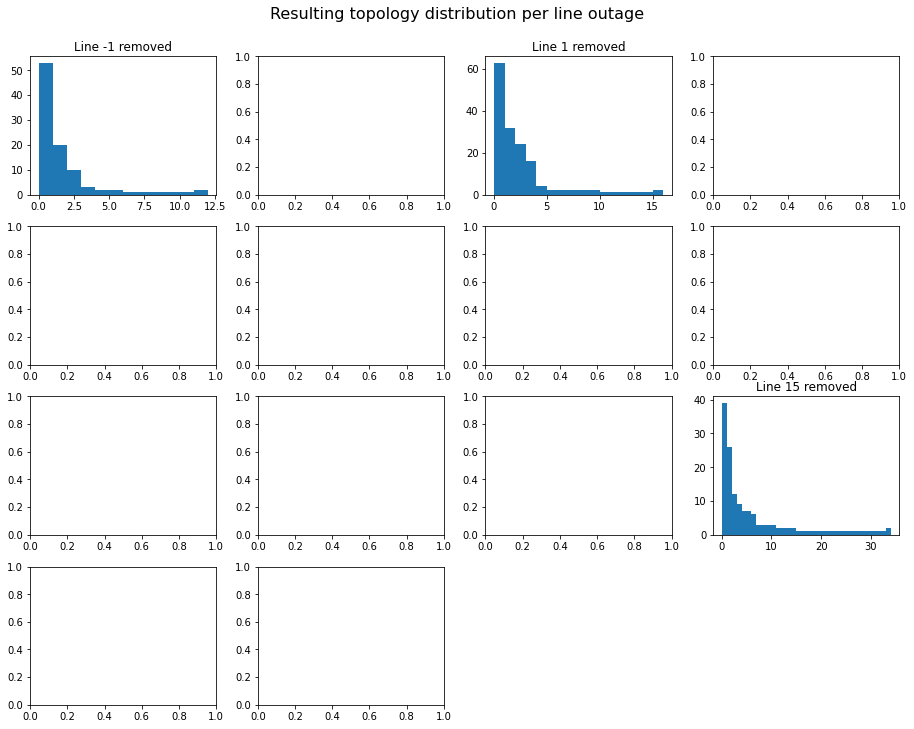

In [22]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_consider):
    res_counter = counters[c_i]['res_hash']
    if not res_counter:
        continue
    val, weight = zip(*[(i, v) for i,(k,v) in enumerate(res_counter.most_common())])
    axs[plt_i].hist(val[0:100], weights=weight[0:100],bins=val[0:100])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Resulting topology distribution per line outage', fontsize=16, y=1.05)

### Substations acted on

In [23]:
substations_with_actions = [1,2,3,4,5,8,12,-1]

In [24]:
np.array(counters[c_i]['sub_changed'])[substations_with_actions]

array([0, 0, 0, 0, 0, 0, 0, 0])

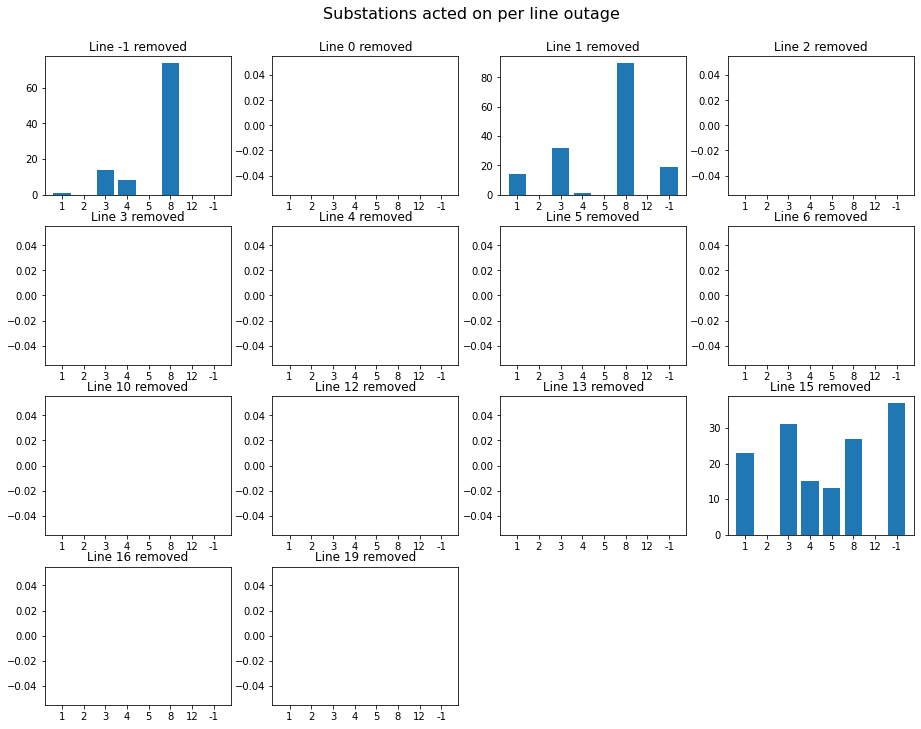

In [25]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_consider):
    axs[plt_i].bar([str(b) for b in substations_with_actions],
                   np.array(counters[c_i]['sub_changed'])[substations_with_actions])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Substations acted on per line outage', fontsize=16, y=1.05)

Text(0.5, 1, 'Distribution of Substations Acted On')

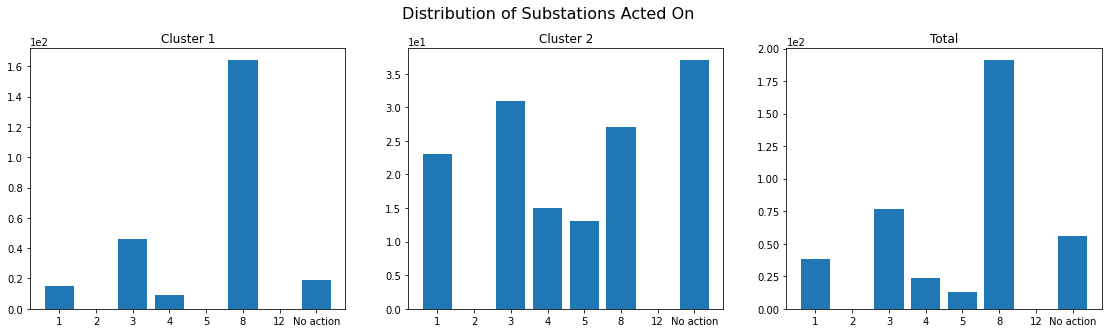

In [26]:
fig, axs = plt.subplots(1,3,figsize=[3*6.4, 1*4.8])

axs[0].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_group1]),axis=0)[substations_with_actions])
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].set_title('Cluster 1')

axs[1].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_group2]),axis=0)[substations_with_actions])
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].set_title('Cluster 2')

axs[2].bar([str(l) for l in substations_with_actions[:-1]] + ['No action'],
        np.sum(np.array([counters[c_i]['sub_changed'] \
                                                   for c_i in line_disabled_to_consider]),axis=0)[substations_with_actions])
axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[2].set_title('Total')

fig.suptitle('Distribution of Substations Acted On', fontsize=16, y=1)
fig.savefig('figures/distribution_substations.png', dpi=300)
#TODO: remove susbtations that never have any actions

### Topological Depth

In [27]:
do_nothing_action_hashes = [h for h,t in hash_to_act.items() if sum(t)==0]
def mean_index(lst):
    return np.sum(np.array([i*v for i,v in enumerate(lst)]))/sum(lst)
[(k,mean_index(v['changed_subs_n']))
 for k,v in counters.items() if k in line_disabled_to_consider]

<ipython-input-27-a35de823d72d>:3: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(np.array([i*v for i,v in enumerate(lst)]))/sum(lst)


[(-1, 1.1134020618556701),
 (0, nan),
 (1, 1.1987179487179487),
 (2, nan),
 (3, nan),
 (4, nan),
 (5, nan),
 (6, nan),
 (10, nan),
 (12, nan),
 (13, nan),
 (15, 1.3904109589041096),
 (16, nan),
 (19, nan)]

mean topological depth

In [28]:
print('Total:',
    mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_disabled_to_consider ]),axis=0)))
print('Group 1:',
      mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_group1 ]),axis=0)))
print('Group 2:',
    mean_index(np.sum(np.array([v['changed_subs_n'] for k,v in counters.items() 
                            if k in line_group2 ]),axis=0)))

Total: 1.2481203007518797
Group 1: 1.1660079051383399
Group 2: 1.3904109589041096


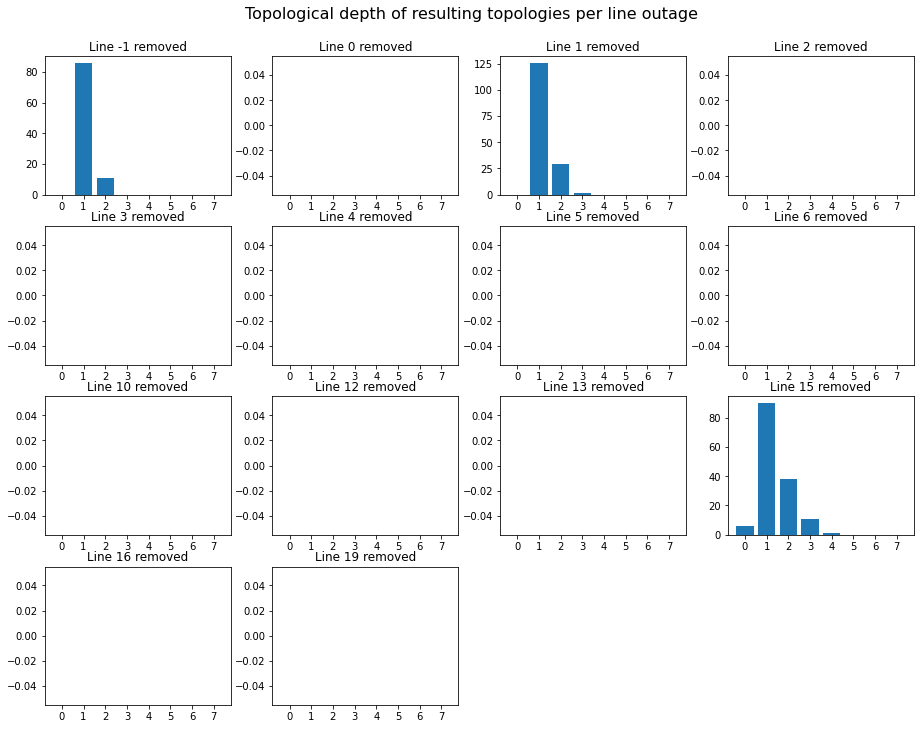

In [29]:
fig, axs = plt.subplots(4,4,figsize=[2*6.4, 2*4.8])#, sharex=True, sharey=True)
axs = axs.reshape(-1)
fig.tight_layout()
for plt_i, c_i in enumerate(line_disabled_to_consider):
    axs[plt_i].bar([str(n) for n in range(len(substations_with_actions))],
                   counters[c_i]['changed_subs_n'][0:len(substations_with_actions)])
    axs[plt_i].title.set_text(f'Line {c_i} removed')

for i in range(len(axs)-len(line_disabled_to_consider)):
    axs[len(axs)-i-1].axis('off')
    
_ = fig.suptitle('Topological depth of resulting topologies per line outage', fontsize=16, y=1.05)

Text(0.5, 1.0, '')

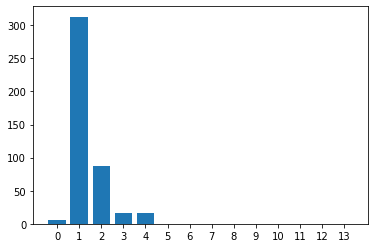

In [30]:
plt.bar([str(n) for n in range(n_sub)],np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                        for c_i in np.arange(-1,20)]),axis=0))
plt.title('')

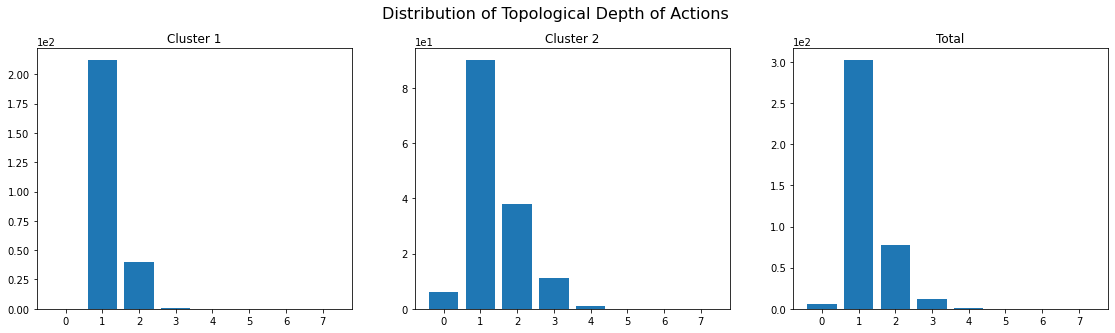

In [31]:
fig, axs = plt.subplots(1,3,figsize=[3*6.4, 1*4.8])

axs[0].bar(range(len(substations_with_actions)),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_group1]),axis=0)[0:8])
axs[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[0].set_title('Cluster 1')

axs[1].bar(range(len(substations_with_actions)),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_group2]),axis=0)[0:8])
axs[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[1].set_title('Cluster 2')

axs[2].bar(range(len(substations_with_actions)),
        np.sum(np.array([counters[c_i]['changed_subs_n'] \
                                                   for c_i in line_disabled_to_consider]),axis=0)[0:8])
axs[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axs[2].set_title('Total')


fig.suptitle('Distribution of Topological Depth of Actions', fontsize=16, y=1)
fig.savefig('figures/distribution_topological_depth.png', dpi=300)
#TODO: remove susbtations that never have any actions